In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Append the directory to your python path using sys
import sys
import os
prefix = '/content/drive/My Drive/'
# modify "customized_path_to_your_homework" here to where you uploaded your homework
customized_path_to_your_homework = 'Colab Notebooks/'
sys_path = prefix + customized_path_to_your_homework
sys.path.append(sys_path)
# print(sys.path)

fp_data = os.path.join(sys_path, 'half_transaction_data.csv')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class Model(nn.Module):
    def __init__(self, in_features=11, h1=10, out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(h1, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.out(x)  # Outputs logits directly
        return x

In [5]:
import pandas as pd
#Pick seed
torch.manual_seed(41)
model = Model()

#Set the criterion of model to measure the error
criterion = nn.BCEWithLogitsLoss()

my_df = pd.read_csv(fp_data)

In [6]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

#Convert X and Y into Numpy arrays
X = my_df.drop('isFraud', axis = 1).astype('float64')
y = my_df['isFraud'].astype('float64')
#print(y.unique())

X = X.values
y = y.values

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3, random_state=42)

rus = RandomUnderSampler(sampling_strategy=0.20, random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

# Convert X to FloatTensors, y to long tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [7]:
#Choose optimizer, learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1250, gamma=0.1)
scheduler_flag = True;
#Train Model

epochs = 5000
losses = []
for i in range(epochs):
  #Forward
  y_pred = model.forward(X_train) #Get predicted results
  #print(type(y_pred))
  #Measure error
  loss = criterion(y_pred.squeeze(), y_train) #predicted vs actual value

  #Keep Track of our losses
  losses.append(loss.detach().numpy())

  #print every  2 epoch (optional)
  if i % 1000 == 0:
    print(f'Epoch: {i} and loss: {loss}')

  #Backprop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  if scheduler_flag:
     scheduler.step()

Epoch: 0 and loss: 42776.51171875
Epoch: 1000 and loss: 0.6071016788482666
Epoch: 2000 and loss: 0.28576910495758057
Epoch: 3000 and loss: 0.23411038517951965
Epoch: 4000 and loss: 0.2453637719154358


Text(0.5, 0, 'epochs')

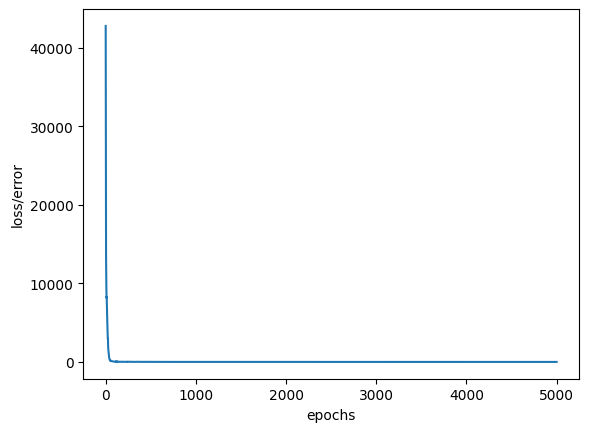

In [8]:
import matplotlib.pyplot as plt
plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel('epochs')

In [9]:
with torch.no_grad(): #Turns off backprop
  y_eval = model.forward(X_test)
  loss = criterion(y_eval.squeeze(), y_test) #Find the loss or error

print(loss)

tensor(0.1048)


Correct Count: 316681
Incorrect Count: 1450
True Positives: 1645
False Negatives: 852
False Positives: 598
F1 Score: 0.6940928270042195
Roc_AUC: 0.933816454080361


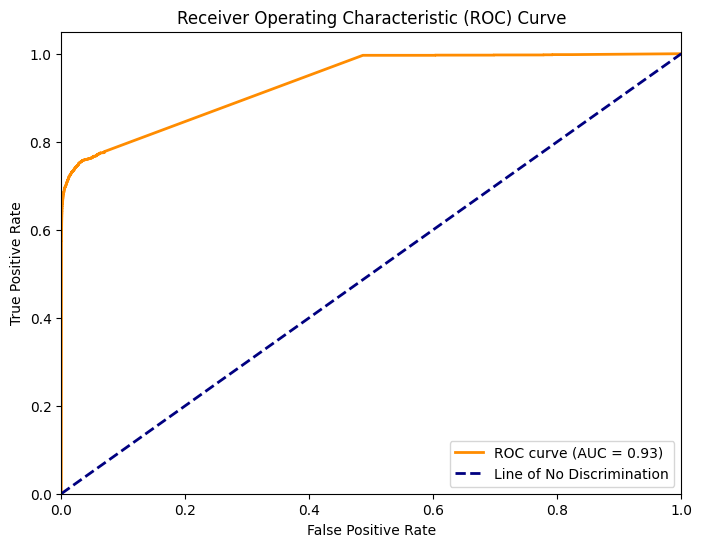

In [10]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Initialize counters and lists to hold logits and labels
correct_count = 0
incorrect = 0
true_positive = 0
false_negative = 0
false_positive = 0
logits_list = []
y_test_list = []

# Assuming 'model' is your trained model and 'X_test', 'y_test' are your test data and labels.
model.eval()
with torch.no_grad():
    for i, data in enumerate(X_test):
        # Reshape data if necessary, depending on your model's input requirements
        data = data.view(1, -1)  # Adjust the reshaping as needed

        # Get model output
        logits = model(data)
        logits_list.append(logits)
        y_test_list.append(y_test[i])

        # Convert logits to probabilities to determine the predicted class
        probabilities = torch.sigmoid(logits)
        predicted_class = 1 if probabilities > 0.6 else 0  # Adjust threshold if needed

        # Update counters based on predictions
        if predicted_class == y_test[i]:
            correct_count += 1
        else:
            incorrect += 1
        if predicted_class == 0 and y_test[i] == 1:
            false_negative += 1
        elif predicted_class == 1 and y_test[i] == 0:
            false_positive += 1
        elif predicted_class == 1 and y_test[i] == 1:
            true_positive += 1

# Print classification metrics
print("Correct Count:", correct_count)
print("Incorrect Count:", incorrect)
print("True Positives:", true_positive)
print("False Negatives:", false_negative)
print("False Positives:", false_positive)

# Calculate precision, recall, and F1 score
recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print("F1 Score:", f1_score)

# Prepare data for ROC curve
logits_array = torch.cat(logits_list).numpy()
y_test_array = np.array(y_test_list)
probabilities_array = torch.sigmoid(torch.tensor(logits_array)).numpy()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_array, probabilities_array)
roc_auc = auc(fpr, tpr)
print('Roc_AUC:', roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Line of No Discrimination')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
'''
correct = 0
incorrect = 0
true_positive = 0
false_negative = 0
false_positive = 0
correct_count = 0
#print(len(X_test)) 212088

model.eval()
with torch.no_grad():
    for i, data in enumerate(X_test):
        # Reshape data if necessary, depending on your model's input requirements
        data = data.view(1, -1)  # Example reshape for a single sample, adjust as needed

        y_val = model(data)

        # Directly use logits (y_val) to determine the predicted class
        predicted_class = 1 if y_val > 0 else 0
        if predicted_class == y_test[i]:
            correct_count += 1
        else:
          incorrect += 1

        if predicted_class == 0 and y_test[i] == 1:
            false_negative += 1  # False negative = predicted false but actually true
        elif predicted_class == 1 and y_test[i] == 0:  # False positive = predicted true but actually false
            false_positive += 1
        elif predicted_class == 1 and y_test[i] == 1:  # True positive
            true_positive += 1

print("Correct Count:", correct_count)
print("Incorrect Count", incorrect)
print("True Positives:", true_positive)
print("False Negatives:", false_negative)
print("False Positives:", false_positive)

recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("F1 Score:", f1_score)
'''

'\ncorrect = 0\nincorrect = 0\ntrue_positive = 0\nfalse_negative = 0\nfalse_positive = 0\ncorrect_count = 0\n#print(len(X_test)) 212088\n\nmodel.eval()\nwith torch.no_grad():\n    for i, data in enumerate(X_test):\n        # Reshape data if necessary, depending on your model\'s input requirements\n        data = data.view(1, -1)  # Example reshape for a single sample, adjust as needed\n\n        y_val = model(data)\n\n        # Directly use logits (y_val) to determine the predicted class\n        predicted_class = 1 if y_val > 0 else 0\n        if predicted_class == y_test[i]:\n            correct_count += 1\n        else:\n          incorrect += 1\n\n        if predicted_class == 0 and y_test[i] == 1:\n            false_negative += 1  # False negative = predicted false but actually true\n        elif predicted_class == 1 and y_test[i] == 0:  # False positive = predicted true but actually false\n            false_positive += 1\n        elif predicted_class == 1 and y_test[i] == 1:  # T

In [ ]:
'''
from sklearn.metrics import roc_curve, auc
import numpy as np


model.eval()

with torch.no_grad():
  logits = model(X_test)

probabilities = torch.sigmoid(logits).numpy()
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
print(roc_auc)
# ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
# Line of no discrimination
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Line of No Discrimination')

# Setting the plot's labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
# Adding the legend to the plot
plt.legend(loc="lower right")
plt.show()
'''

'\nfrom sklearn.metrics import roc_curve, auc\nimport numpy as np\n\n\nmodel.eval()\n\nwith torch.no_grad():\n  logits = model(X_test)\n\nprobabilities = torch.sigmoid(logits).numpy()\nfpr, tpr, thresholds = roc_curve(y_test, probabilities)\nroc_auc = auc(fpr, tpr)\n\nplt.figure(figsize=(8, 6))\nprint(roc_auc)\n# ROC curve\nplt.plot(fpr, tpr, color=\'darkorange\', lw=2, label=\'ROC curve (AUC = %0.2f)\' % roc_auc)\n# Line of no discrimination\nplt.plot([0, 1], [0, 1], color=\'navy\', lw=2, linestyle=\'--\', label=\'Line of No Discrimination\')\n\n# Setting the plot\'s labels and title\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.title(\'Receiver Operating Characteristic (ROC) Curve\')\n# Adding the legend to the plot\nplt.legend(loc="lower right")\nplt.show()\n'